In [1]:
import numpy as np
import torch
from torchviz import make_dot
from argparse import Namespace
import json
import matplotlib.pyplot as plt

import sys, os

src_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

sys.path.insert(0, src_root)

from src.models.SINDyConvAE_o2 import Net
from src.utils.model_utils import sindy_library, build_equation_labels

In [2]:
sess_name = '05-25-2025_0'
args_path = f'/home/jared/Projects/SINDy/SINDy_Autoencoder_PyTorch_EP/trained_models/elastic_pendulum/SINDyConvAE_o2/{sess_name}/args.txt'
cp_path = f'/home/jared/Projects/SINDy/SINDy_Autoencoder_PyTorch_EP/trained_models/elastic_pendulum/SINDyConvAE_o2/{sess_name}/checkpoint.pt'

In [3]:
args = json.load(open(args_path, 'r'))
args = Namespace(**args)
print(args.__dict__)

{'session_name': '05-25-2025_0', 'model': 'SINDyConvAE_o2', 'experiments': './experiments/', 'model_folder': './trained_models/', 'tensorboard_folder': './tb_runs/', 'data_set': 'elastic_pendulum', 'z_dim': 2, 'u_dim': 2601, 'hidden_dims': [128, 64, 32], 'use_inverse': True, 'use_sine': True, 'use_cosine': True, 'poly_order': 3, 'include_constant': True, 'nonlinearity': 'elu', 'epochs': 500, 'learning_rate': 0.001, 'adam_regularization': 1e-05, 'gamma_factor': 0.995, 'batch_size': 30, 'lambda_ddx': 0.0, 'lambda_ddz': 0.0, 'lambda_reg': 0.0, 'clip': None, 'test_interval': 1, 'checkpoint_interval': 1, 'sequential_threshold': 0.05, 'spring_constant': 24.0, 'mass': 1.0, 'natural_length': 1.0, 'gravitational_acceleration': 9.81, 'train_initial_conds': 200, 'val_initial_conds': 20, 'test_initial_conds': 20, 'timesteps': 500, 'load_cp': 0, 'device': 0, 'print_folder': 1}


In [4]:
torch.cuda.set_device(args.device)
device = torch.cuda.current_device()

In [5]:
net = Net(args)
checkpoint = torch.load(cp_path, map_location="cuda:" + str(device))
net.load_state_dict(checkpoint['model'])
net.to(device)

/tmp/ipykernel_916071/2322887591.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cp_path, map_location="cuda:" + str(device))


Net(
  (mse): MSELoss()
  (enc1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (enc2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (enc3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc_enc): Linear(in_features=3136, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=3136, bias=True)
  (dec1): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (dec2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (dec3): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
)

In [6]:
test = np.load('/home/jared/Projects/SINDy/SINDy_Autoencoder_PyTorch_EP/data/elastic_pendulum/test.npy', allow_pickle=True)
test = test.item()
test.keys()

dict_keys(['t', 'x', 'dx', 'ddx', 'z', 'dz'])

In [7]:
num_samples = 100

x = torch.Tensor(test['x'][:num_samples]).to(device)
dx = torch.Tensor(test['dx'][:num_samples]).to(device)
ddx = torch.Tensor(test['ddx'][:num_samples]).to(device)

lambdas = args.lambda_ddx, args.lambda_ddz, args.lambda_reg

In [8]:
net(x, dx, ddx, lambdas)

(tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'))

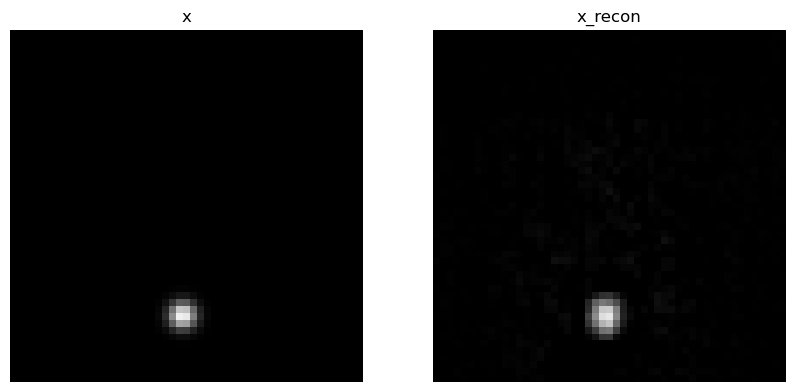

In [9]:
frame = 77

x_frame = x[frame].view(net.u_w, net.u_w).detach().cpu().numpy()
x_recon_frame = net.decoder(net.encoder(x[frame])).view(net.u_w, net.u_w).detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(x_frame, cmap='gray', origin='lower', vmin=0, vmax=1)
axes[0].axis('off')
axes[0].set_title("x")
axes[1].imshow(x_recon_frame, cmap='gray', origin='lower', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title("x_recon")

plt.show()

In [10]:
net.mse(x[frame].view(-1, net.u_dim), net.decoder(net.encoder(x[frame])))

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)

In [11]:
np.min(x_recon_frame), np.max(x_recon_frame)

(np.float32(-0.14980173), np.float32(0.8992975))

In [12]:
x_pred = net(x, dx, ddx, lambdas)
x_pred

(tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [13]:
make_dot(x_pred[0], params=dict(net.named_parameters())).render("AE", format="png")

'AE.png'

In [14]:
z = torch.Tensor(test['z'][:5]).to(device)
dz = torch.Tensor(test['dz'][:5]).to(device)

In [15]:
labels = build_equation_labels(2, 3, True, True, True, True)
labels, len(labels)

(['1',
  'X',
  'Y',
  'Xdot',
  'Ydot',
  '1/X',
  '1/Y',
  'sin(X)',
  'sin(Y)',
  'cos(X)',
  'cos(Y)',
  'X*X',
  'X*Y',
  'X*Xdot',
  'X*Ydot',
  'X*1/X',
  'X*1/Y',
  'X*sin(X)',
  'X*sin(Y)',
  'X*cos(X)',
  'X*cos(Y)',
  'Y*Y',
  'Y*Xdot',
  'Y*Ydot',
  'Y*1/X',
  'Y*1/Y',
  'Y*sin(X)',
  'Y*sin(Y)',
  'Y*cos(X)',
  'Y*cos(Y)',
  'Xdot*Xdot',
  'Xdot*Ydot',
  'Xdot*1/X',
  'Xdot*1/Y',
  'Xdot*sin(X)',
  'Xdot*sin(Y)',
  'Xdot*cos(X)',
  'Xdot*cos(Y)',
  'Ydot*Ydot',
  'Ydot*1/X',
  'Ydot*1/Y',
  'Ydot*sin(X)',
  'Ydot*sin(Y)',
  'Ydot*cos(X)',
  'Ydot*cos(Y)',
  '1/X*1/X',
  '1/X*1/Y',
  '1/X*sin(X)',
  '1/X*sin(Y)',
  '1/X*cos(X)',
  '1/X*cos(Y)',
  '1/Y*1/Y',
  '1/Y*sin(X)',
  '1/Y*sin(Y)',
  '1/Y*cos(X)',
  '1/Y*cos(Y)',
  'sin(X)*sin(X)',
  'sin(X)*sin(Y)',
  'sin(X)*cos(X)',
  'sin(X)*cos(Y)',
  'sin(Y)*sin(Y)',
  'sin(Y)*cos(X)',
  'sin(Y)*cos(Y)',
  'cos(X)*cos(X)',
  'cos(X)*cos(Y)',
  'cos(Y)*cos(Y)',
  'X*X*X',
  'X*X*Y',
  'X*X*Xdot',
  'X*X*Ydot',
  'X*X*1/X',
  'X*